In [1]:
import pandas as pd
from dataset import Dataset
from dataread import Dataread
import seaborn as sns
import matplotlib.pyplot as plt
import os
import fsspec
import pyarrow.parquet as pq

plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False

ds = Dataset()
dr = Dataread()
JSON_KEY_PATH = "./sprintda05-soomin.json"
os.environ["GOOGlE_APPLICATION_CREDENTIALS"] = JSON_KEY_PATH
fs = fsspec.filesystem("gcs")


In [16]:
# day 별 
def daycounter(df):
    day0 = pd.to_datetime('2023-05-01')
    day1 = pd.to_datetime('2023-05-01') + pd.Timedelta(days=1)
    result = {}
    while True:
        mask1 = df['created_at'] > day0
        mask2 = df['created_at'] < day1
        
        try:
            result[day.strftime('%Y-%m-%d')] = df.loc[(mask1) & (mask2), 'user_id'].nunique()
        except:
            result[day.strftime('%Y-%m-%d')] = df.loc[(mask1) & (mask2), 'id'].nunique()
        
        if day1 > pd.to_datetime('2023-08-01'):
            break
        day0 = day0 + pd.Timedelta(days=1)
        day1 = day1 + pd.Timedelta(days=1)

    result_df = pd.DataFrame(list(result.items()), columns=['day', 'count'])
    return result_df

In [39]:
# day 별 누적
def dayculcounter(df):
    day = pd.to_datetime('2023-05-01')
    result = {}
    while True:
        mask2 = df['created_at'] <= day
        
        try:
            result[day.strftime('%Y-%m-%d')] = df.loc[(mask2), 'user_id'].nunique()
        except:
            result[day.strftime('%Y-%m-%d')] = df.loc[(mask2), 'id'].nunique()
        
        if day >= pd.to_datetime('2023-08-01'):
            break
        day = day + pd.Timedelta(days=1)

    result_df = pd.DataFrame(list(result.items()), columns=['day', 'count'])
    return result_df

In [6]:
# 투표한 유저수 통합 테이블 구성
df = ds.votes.accounts_userquestionrecord()
reported_user_list = ds.votes.accounts_timelinereport()['reported_user_id'].unique()
vote_user_df = df.loc[df['status'] != 'B'].copy()
vote_user_df = vote_user_df.loc[vote_user_df['user_id'].isin(reported_user_list) == False]

In [7]:
vote_user_df


,id,status,created_at,chosen_user_id,question_id,user_id,question_piece_id,has_read,answer_status,answer_updated_at,report_count,opened_times
0,771777,C,2023-04-28 12:27:49,849469,252,849436,998458,0,N,2023-04-28 12:27:49,0,0
1,771800,C,2023-04-28 12:28:02,849446,244,849436,998459,0,N,2023-04-28 12:28:02,0,0
2,771812,C,2023-04-28 12:28:09,849454,183,849436,998460,1,N,2023-04-28 12:28:09,0,0
3,771828,C,2023-04-28 12:28:16,847375,101,849436,998461,0,N,2023-04-28 12:28:16,0,0
4,771851,C,2023-04-28 12:28:26,849477,209,849436,998462,1,N,2023-04-28 12:28:26,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1217553,161666166,C,2024-05-07 11:29:07,945560,2614,1001607,190864020,1,N,2024-05-07 11:29:07,0,0
1217554,161666461,C,2024-05-08 01:34:56,850774,1679,855525,200139931,0,N,2024-05-08 01:34:56,0,0
1217555,161666462,C,2024-05-08 01:35:02,855509,2605,855525,200139932,0,N,2024-05-08 01:35:02,0,0
1217556,161666463,C,2024-05-08 01:36:00,855526,3801,855525,200139933,0,N,2024-05-08 01:36:00,0,0


In [8]:
day_vote_user_df = daycounter(vote_user_df)
day_vote_user_df

,day,count
0,2023-05-01,324
1,2023-05-02,411
2,2023-05-03,752
3,2023-05-04,814
4,2023-05-05,1232
...,...,...
87,2023-07-27,14
88,2023-07-28,14
89,2023-07-29,17
90,2023-07-30,11


In [19]:
temp = ds.votes.accounts_user()
temp = temp.loc[temp['created_at'] < '2023-08-01']

In [41]:
cul_with_draw_df = dayculcounter(ds.votes.accounts_userwithdraw())

In [40]:
cul_user_df = dayculcounter(ds.votes.accounts_user())
cul_user_df

,day,count
0,2023-05-01,19093
1,2023-05-02,23733
2,2023-05-03,27804
3,2023-05-04,32035
4,2023-05-05,35508
...,...,...
88,2023-07-28,673090
89,2023-07-29,673121
90,2023-07-30,673146
91,2023-07-31,673161


In [42]:
cul_with_draw_df

,day,count
0,2023-05-01,2414
1,2023-05-02,2886
2,2023-05-03,3354
3,2023-05-04,3783
4,2023-05-05,4186
...,...,...
88,2023-07-28,61242
89,2023-07-29,61371
90,2023-07-30,61498
91,2023-07-31,61604


In [43]:
cul_user_df

,day,count
0,2023-05-01,19093
1,2023-05-02,23733
2,2023-05-03,27804
3,2023-05-04,32035
4,2023-05-05,35508
...,...,...
88,2023-07-28,673090
89,2023-07-29,673121
90,2023-07-30,673146
91,2023-07-31,673161


Q. withdraw한 유저가 account에 존재하는가? (탈퇴한 회원의 기록도, accounts_user 에 남아있는가의 문제. 없어졌다면, 굳이 withdraw유저의 숫자를 뺄 필요 없음.
이래저래 확신할 수 없으니 팀적으로 합의만 보면 될 듯)

In [60]:
import matplotlib.dates as mdates

def index_maker(cul_user_df, day_vote_user_df):
        
    merged_df = pd.merge(cul_user_df, day_vote_user_df, on ='day', suffixes=['_user','_vote'], how = 'left')
    merged_df = merged_df.iloc[:-1]
    merged_df['ratio'] = round(merged_df['count_vote'] / merged_df['count_user'] * 100,4)
    index_graph(merged_df)
    display(merged_df)

    return merged_df

# 지표 라인 그래프 그리기
def index_graph(merged_df):
    merged_df['day'] = pd.to_datetime(merged_df['day'])
    plt.figure(figsize=(10,6))
    ax = sns.lineplot(data=merged_df, x='day', y='ratio')

    ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MO, interval=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))

    ax.set_title('Day별 투표율')
    ax.set_ylabel('투표율')
    ax.set_xlabel('Day')

    plt.tight_layout()
    plt.show()
    return


### 1. withdraw 유저를 빼지 않은 경우

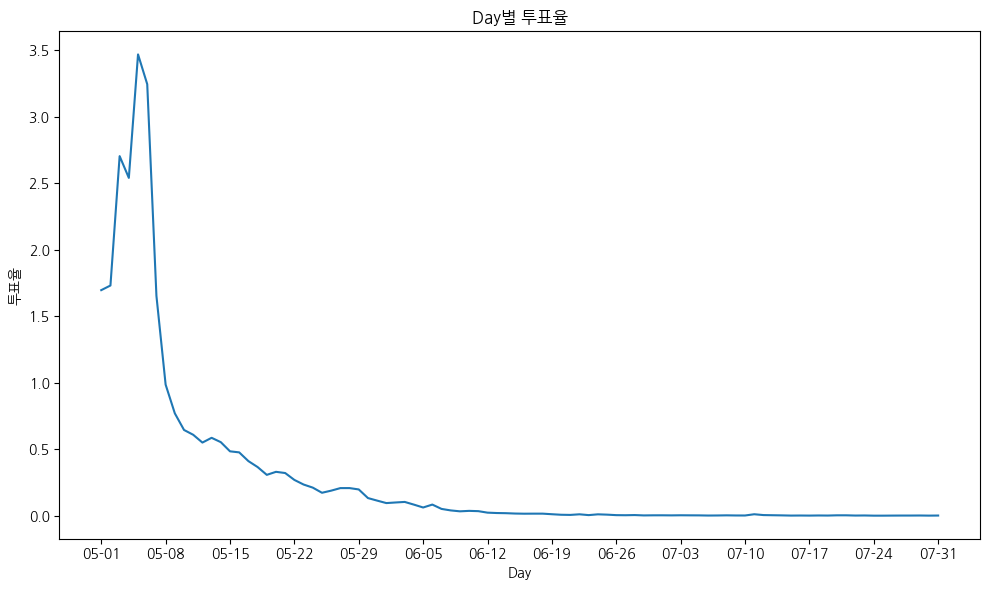

,day,count_user,count_vote,ratio
0,2023-05-01,19093,324.0,1.6970
1,2023-05-02,23733,411.0,1.7318
2,2023-05-03,27804,752.0,2.7046
3,2023-05-04,32035,814.0,2.5410
4,2023-05-05,35508,1232.0,3.4696
...,...,...,...,...
87,2023-07-27,673057,14.0,0.0021
88,2023-07-28,673090,14.0,0.0021
89,2023-07-29,673121,17.0,0.0025
90,2023-07-30,673146,11.0,0.0016


In [61]:
merged_df = index_maker(cul_user_df, day_vote_user_df)

### 2. withdraw 유저를 뺀 경우

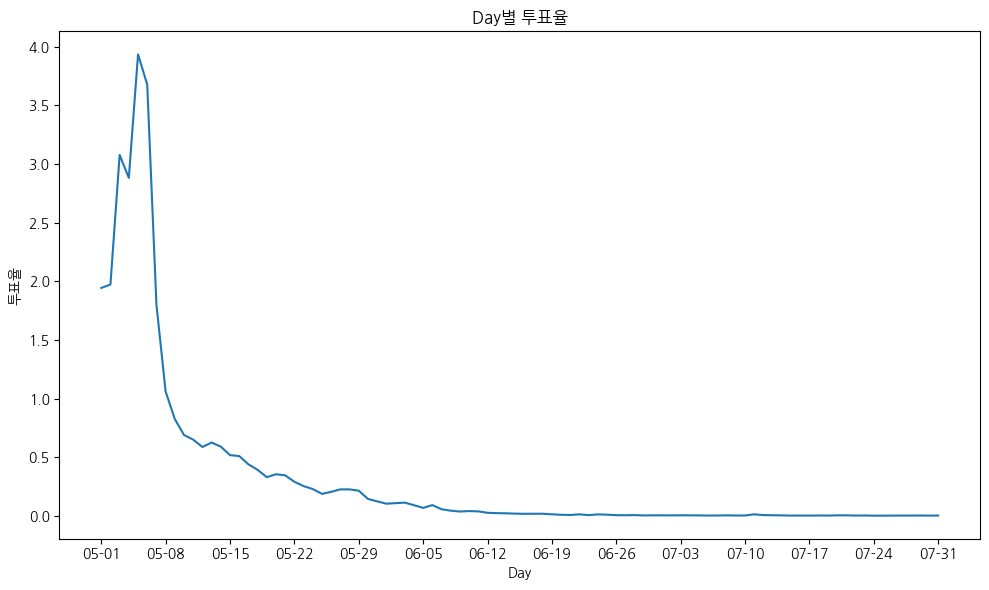

,day,count_user,count_vote,ratio
0,2023-05-01,16679,324.0,1.9426
1,2023-05-02,20847,411.0,1.9715
2,2023-05-03,24450,752.0,3.0757
3,2023-05-04,28252,814.0,2.8812
4,2023-05-05,31322,1232.0,3.9333
...,...,...,...,...
87,2023-07-27,611933,14.0,0.0023
88,2023-07-28,611848,14.0,0.0023
89,2023-07-29,611750,17.0,0.0028
90,2023-07-30,611648,11.0,0.0018


In [63]:
cul_user_withdraw_df = pd.DataFrame()
cul_user_withdraw_df['day'] = cul_user_df['day']
cul_user_withdraw_df['count'] = cul_user_df['count'] - cul_with_draw_df['count']

merged_df = index_maker(cul_user_withdraw_df, day_vote_user_df)